In [1]:
using DifferentialEquations
using Plots, PlotThemes, LinearAlgebra
theme(:dao)

In [2]:
struct CRMParams
    c::Matrix{Float64}
    e::Matrix{Float64}
    K::Vector{Float64}
    m::Vector{Float64}
    S::Int64
    M::Int64
    CRMParams(c,e,K,m) = size(c,1)==size(m,1) && size(c,2)==size(K,1) && size(c) == size(e) ? new(c,e,K,m,size(m)[1],size(K)[1]) : error("wrong dimensions")
end

In [310]:
function CRM!(du,u,p,t)
    λ = @view u[1:p.S]
    dλ = @view du[1:p.S]
    R = @view u[end+1-p.M:end]
    dR = @view du[end+1-p.M:end]
    dλ .= λ .* (p.c * R .- p.m)
    dR .= R .* (p.K .- R .-  p.e' * λ)
end

CRM! (generic function with 1 method)

In [272]:
M = 200;
S = 200;
# μc = 1e0;
# μX = 1e0;
# σc = 2e-1;
# σX = 2e-1;
μc = 1e0M;
μX = 1e0M;
σc = 2e-1sqrt(M);
σX = 2e-1sqrt(M);
K = 1e0;
σK = 1e-1;
m = 1e0;
σm = 1e-1;

In [311]:
using BenchmarkTools


params = (μc/M .+ (σc/sqrt(M))*randn(M,S)) |> c -> CRMParams(c,(1.0-a)*c .+ a*(μX/M .+ (σX/sqrt(M))*randn(M,S)),K0,m .+ σm*randn(S))

function runATest()
    duTest = rand(400);
    uTest = rand(400);
    CRM!(duTest,uTest,params,0);
end
@benchmark runATest() #is faster if we use @view macro

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   8.723 μs … 149.702 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     12.873 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   15.598 μs ±   8.501 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▃▆███▇▇▇▆▆▅▅▄▄▄▃▃▃▂▂▁▂▂▁▁▁▁▁▁▁▁ ▁                            ▃
  ████████████████████████████████████▇███▇█▇▇▇▆▇▆▆▆▆▇▆▇▆▆▅▆▅▅ █
  8.72 μs       Histogram: log(frequency) by time      50.3 μs <

 Memory estimate: 10.08 KiB, allocs estimate: 5.

In [273]:
# using ODEInterfaceDiffEq
# using LSODA
using ODEInterfaceDiffEq
# using OrdinaryDiffEq

In [284]:
K0 = K .+ σK*randn(M);
u0=vcat(1e-1ones(S)/S,K0)
# u0=vcat(ones(S)/S,K0)
# a=0.77
# a=0.6
a=0.77
params = (μc/M .+ (σc/sqrt(M))*randn(M,S)) |> c -> CRMParams(c,(1.0-a)*c .+ a*(μX/M .+ (σX/sqrt(M))*randn(M,S)),K0,m .+ σm*randn(S))

tspan=(0.0,2000.0);
prob = ODEProblem(CRM!,u0,tspan,params);
sol = solve(prob,abstol=1e-12,reltol=1e-12,saveat=5);

In [285]:
pλ = plot(sol,idxs=(1:S),ylim=(0,:auto),label=:none)
pR = plot(sol,idxs=((S + 1):(M+S)),ylim=(0,:auto),label=:none)
l = @layout([a;b])
plot(pλ,pR,layout=l)

In [292]:
using BenchmarkTools

In [288]:
function getASol(a)
    params = (μc/M .+ (σc/sqrt(M))*randn(M,S)) |> c -> CRMParams(c,(1.0-a)*c .+ a*(μX/M .+ (σX/sqrt(M))*randn(M,S)),K0,m .+ σm*randn(S))

    tspan=(0.0,2000.0);
    prob = ODEProblem(CRM!,u0,tspan,params);
    sol = solve(prob,abstol=1e-12,reltol=1e-12,saveat=4);
    return sol
end

getASol (generic function with 1 method)

In [305]:
# hcat(getASol(0.0).u[end-100:end]...)
avgFinalDerivs(a) = hcat(getASol(a)(800:1000,Val{1}).u...)# |> X -> sum(abs.(X))/size(X,1)

avgFinalDerivs (generic function with 1 method)

In [313]:
test = getASol(0.8);

In [339]:
# test(1900:2500)
# test.t
test(1600.0:2:2000.0,Val{1})

t: 1600.0:2.0:2000.0
u: 201-element Vector{Vector{Float64}}:
 [6.689521968575359e-214, 4.396222352861166e-254, -6.94957355058021e-143, -1.1508534214787787e-145, -4.770143431512028e-98, 9.108916082063113e-199, -1.418272376594608e-126, -2.8347314814883854e-167, -5.926782979658917e-135, 2.702137466420451e-7  …  -8.082448217792396e-68, -2.9282250342866634e-95, 9.149285679113743e-224, -2.38753832772555e-310, -7.80121610202653e-247, 0.0, -1.9044357747443156e-261, -5.8364127875267425e-198, -2.3062188700504862e-76, 0.0]
 [-6.857997223171637e-214, -7.696532840703181e-255, -4.403751888024244e-143, -8.753832042755943e-146, -3.033786401737754e-98, -4.504313664099725e-199, -8.938940958871543e-127, -3.469759754157402e-167, -3.683062645534895e-135, 2.60016347314318e-7  …  -6.203197457794472e-68, -1.8922466544183628e-95, -4.941972892193211e-224, 2.605691119886e-311, 9.802151060609173e-248, 0.0, 2.1201413566574113e-262, -4.356449394958597e-197, -1.69889079151345e-76, 0.0]
 [-6.857997223171637e-214, -7.

In [306]:
testp(a) = [avgFinalDerivs(a) for _ in 1:100];
# testp0 = [avgFinalDerivs(0.0) for _ in 1:100];

In [ ]:
trestasdkfm = testp.(0:0.05:1)


In [328]:
mean(abs.(trestasdkfm[end][1]))

8.61912537617054e-5

In [423]:
# trestasdkfm[1] .|> (X -> std.(eachrow(X)))
yyyyMean = (Y -> (Y .|> X -> mean((Z -> mean(abs.(Z[end-100:end]))).(eachrow(X))))).(trestasdkfm);
yyyyStd = (Y -> (Y .|> X -> mean((Z -> std(Z[end-100:end])).(eachrow(X))))).(trestasdkfm);

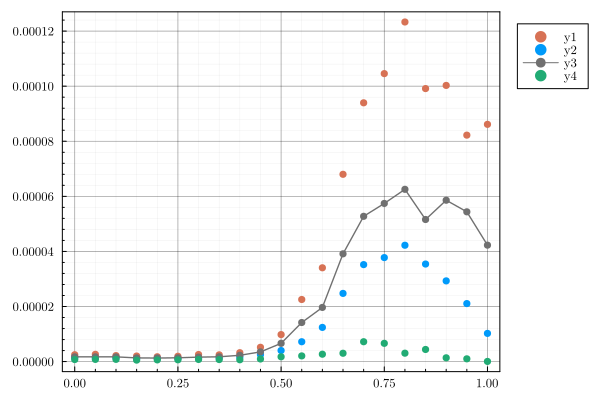

In [424]:

scatter(0:0.05:1,(X->quantile(X,0.8)).(yyyyMean))
scatter!(0:0.05:1,(X->quantile(X,0.5)).(yyyyMean))
plot!(0:0.05:1,mean.(yyyyMean),marker=:circle)
scatter!(0:0.05:1,(X->quantile(X,0.2)).(yyyyMean))

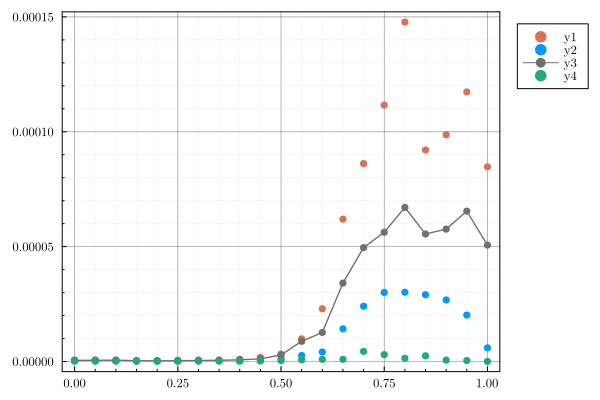

In [425]:

scatter(0:0.05:1,(X->quantile(X,0.8)).(yyyyStd))
scatter!(0:0.05:1,(X->quantile(X,0.5)).(yyyyStd))
plot!(0:0.05:1,mean.(yyyyStd),marker=:circle)
scatter!(0:0.05:1,(X->quantile(X,0.2)).(yyyyStd))

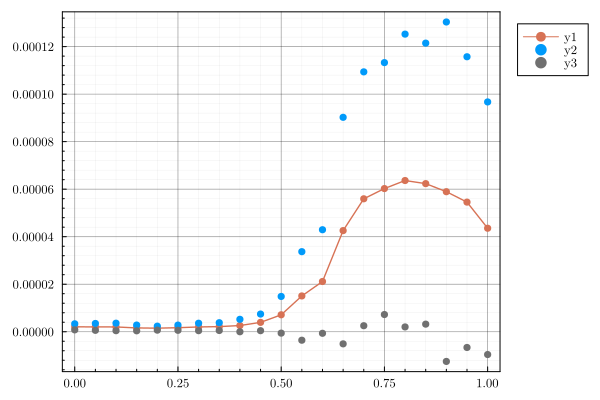

In [361]:
plot(0:0.05:1,trestasdkfm .|> Y -> mean(Y .|> X -> mean(abs.(X))),marker=:circle)
scatter!(0:0.05:1,(trestasdkfm .|> (Y -> mean(Y .|> X -> mean(abs.(X))))) .+ (trestasdkfm .|> (Y -> std(Y .|> X -> mean(abs.(X))))))
scatter!(0:0.05:1,(trestasdkfm .|> (Y -> mean(Y .|> X -> mean(abs.(X))))) .- (trestasdkfm .|> (Y -> std(Y .|> X -> mean(abs.(X))))))

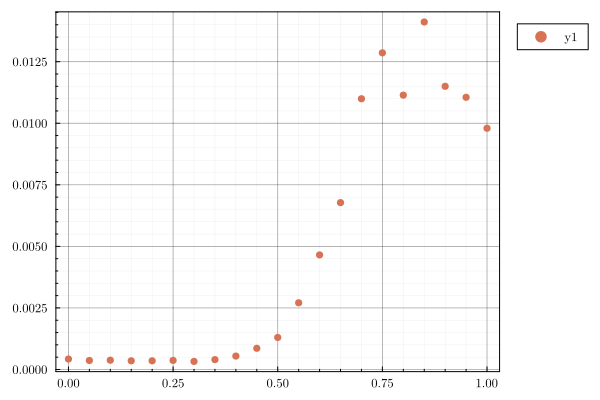

In [302]:
scatter(0:0.05:1,mean.(testt))

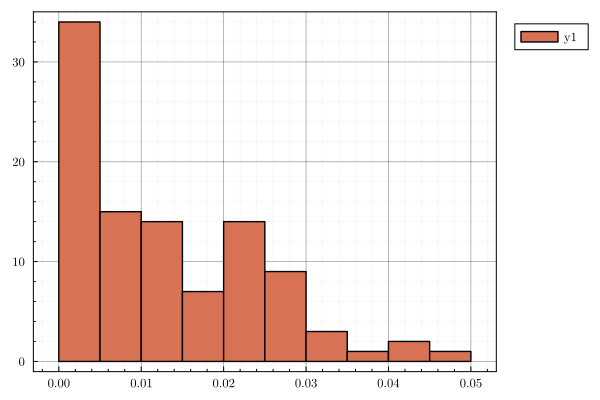

In [282]:
histogram(testp8,bins=20)

In [286]:
using Statistics

In [289]:
mean(testp8)/mean(testp0)

28.946384887519937

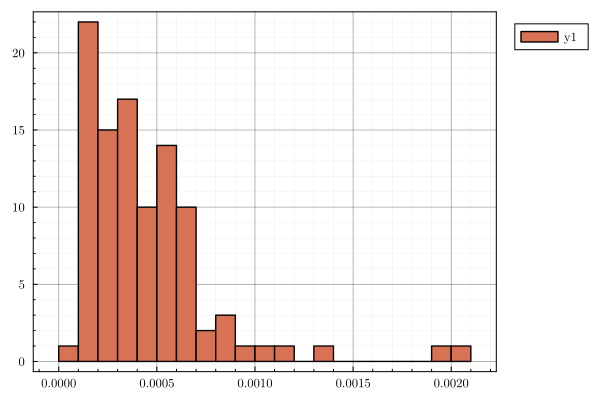

In [283]:
histogram(testp0,bins=20)


In [179]:
function CRMbackwards!(du,u,p,t)
    λ = @view u[1:p.S]
    dλ = @view du[1:p.S]
    R = @view u[end+1-p.M:end]
    dR = @view du[end+1-p.M:end]
    dλ .= -λ .* (p.c * R .- p.m)
    dR .= -R .* (p.K .- R .-  p.e' * λ)
end

CRMbackwards! (generic function with 1 method)

In [63]:
u0backwards = sol.u[end]#vcat(1e-5ones(params.S),params.K);
tspan=(0.0,10.0);
probbackwards = ODEProblem(CRMbackwards!,u0,tspan,params);
solbackwards = solve(probbackwards,Tsit5(),abstol=1e-10,reltol=1e-10);

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.2603555523481884. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/emmyb320/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:516
